In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# path = '../datasets/position_data.csv'
# path = '../training_datasets/virtual_data_example_pkg.csv'
# path = '../datasets/virtual_data_1.csv'
path = './data.csv'

data = pd.read_csv(path)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   x         1000 non-null   float64
 1   y         1000 non-null   float64
 2   pitch     1000 non-null   float64
 3   shoulder  1000 non-null   float64
 4   elbow     1000 non-null   float64
 5   wrist     1000 non-null   float64
dtypes: float64(6)
memory usage: 47.0 KB


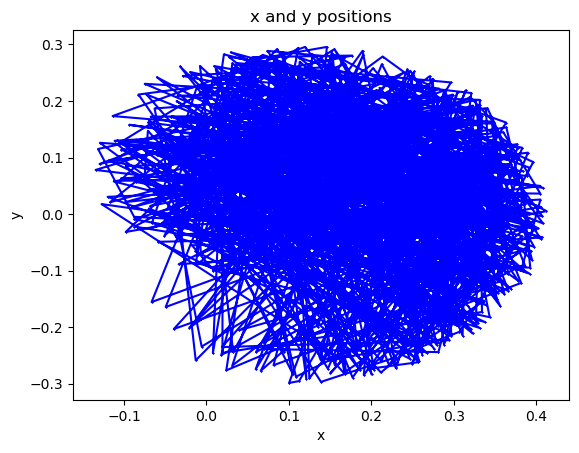

In [4]:
plt.plot(data['x'], data['y'], marker='x', color='blue', markersize=1)

plt.title('x and y positions')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [10]:
# Printing the number of duplicates
# NOTE: the joint angles were generated to be unique and should never contain duplicates
print(f'Duplicate features: {data.duplicated(subset=['x', 'y', 'pitch'], keep=False).sum()}')
print(f'Duplicate labels: {data.duplicated(subset=['shoulder', 'elbow', 'wrist'], keep=False).sum()}')

Duplicate features: 0
Duplicate labels: 0


## Splitting the Data

In [5]:
from sklearn.model_selection import train_test_split

X = data[['x','y','pitch']].to_numpy()
y = data[['shoulder','elbow','wrist']].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

## PyTorch Model

In [7]:
import torch
from torch import nn, optim

class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.hidden_layer = nn.Linear(3, 100)
        self.output_layer = nn.Linear(100, 3)
        self.activation_function = nn.Tanh()

    def forward(self, x):
        x = self.activation_function(self.hidden_layer(x))
        x = self.output_layer(x)
        return x

#### Training Loop

In [8]:
from torch.utils.data import TensorDataset, DataLoader

model = MLPModel()

# transforming data into tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor  = torch.tensor(X_val,  dtype=torch.float32)
y_val_tensor  = torch.tensor(y_val,  dtype=torch.float32)

training_dataset      = TensorDataset(X_train_tensor, y_train_tensor)
validation_dataset = TensorDataset(X_val_tensor, y_val_tensor)

training_dataloader  = DataLoader(training_dataset,      batch_size=4, shuffle=False)
validation_dataloader = DataLoader(validation_dataset, batch_size=4, shuffle=False)


mse = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train_one_epoch():
    # the running loss is the mean of the losses accumulated
    # from a batch
    running_loss = 0
    last_loss = 0
    for i, (inputs, targets) in enumerate(training_dataloader):
        # zeros out the gradients
        optimizer.zero_grad()
        
        # make predictions for this batch
        outputs = model(inputs)
        
        # computes the loss and its gradients
        loss = mse(outputs, targets)
        loss.backward()
        
        # adjust learning weights
        optimizer.step()
        
        running_loss += loss.item()
        # every 1000 batches, compute the mean of the loss
        if i % 1000 == 999:
            # compute the mean of the running_loss
            last_loss = running_loss / 1000
            print(f'  batch {i + 1} loss: {last_loss}')
            running_loss = 0.
    
    return last_loss

epochs = 150

avg_training_losses = []
avg_validation_losses = []

for epoch in range(epochs):
    print(f'Epoch: {epoch+1}')
    model.train(True)
    avg_loss = train_one_epoch()
    running_vloss = 0

    model.eval()

    with torch.no_grad():
        for i, vdata in enumerate(validation_dataloader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = mse(voutputs, vlabels)
            running_vloss += vloss
    
    avg_vloss = running_vloss / (i + 1)

    print(f'LOSS train {avg_loss} valid {avg_vloss}')
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_vloss / len(training_dataloader):.4f}")

    avg_training_losses.append(avg_loss)
    avg_validation_losses.append(avg_vloss)


Epoch: 1
LOSS train 0 valid 1.100563883781433
Epoch [1/150], Loss: 0.2390
Epoch: 2
LOSS train 0 valid 1.0310910940170288
Epoch [2/150], Loss: 0.2239
Epoch: 3
LOSS train 0 valid 0.9836230874061584
Epoch [3/150], Loss: 0.2136
Epoch: 4
LOSS train 0 valid 0.9591353535652161
Epoch [4/150], Loss: 0.2083
Epoch: 5
LOSS train 0 valid 0.9472292065620422
Epoch [5/150], Loss: 0.2057
Epoch: 6
LOSS train 0 valid 0.9409684538841248
Epoch [6/150], Loss: 0.2043
Epoch: 7
LOSS train 0 valid 0.9373937845230103
Epoch [7/150], Loss: 0.2035
Epoch: 8
LOSS train 0 valid 0.9350342750549316
Epoch [8/150], Loss: 0.2030
Epoch: 9
LOSS train 0 valid 0.9331204295158386
Epoch [9/150], Loss: 0.2026
Epoch: 10
LOSS train 0 valid 0.9312939047813416
Epoch [10/150], Loss: 0.2022
Epoch: 11
LOSS train 0 valid 0.9294110536575317
Epoch [11/150], Loss: 0.2018
Epoch: 12
LOSS train 0 valid 0.9274246096611023
Epoch [12/150], Loss: 0.2014
Epoch: 13
LOSS train 0 valid 0.9253221750259399
Epoch [13/150], Loss: 0.2009
Epoch: 14
LOSS tra

#### Plotting training loss and validation loss

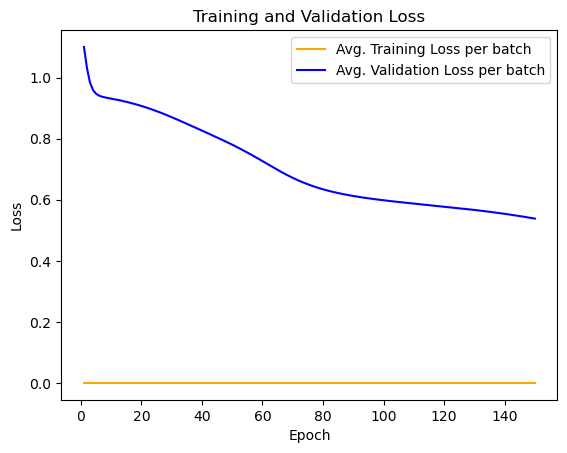

In [9]:
plt.plot(range(1, epochs+1), avg_training_losses, color='orange', label='Avg. Training Loss per batch')
plt.plot(range(1, epochs+1), avg_validation_losses, color='blue', label='Avg. Validation Loss per batch')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()

plt.show()

In [17]:
# save the model's weights
torch.save(model.state_dict(), '/home/xavier/projects/ik_solver_with_ml/model.state_dict')

## Scikit Learn Model

In [12]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(
    hidden_layer_sizes=(100,),
    activation='tanh',
    max_iter=500,
    warm_start=True
)

model.fit(X_train, y_train)

MLPRegressor(activation='tanh', max_iter=5000, warm_start=True)

In [13]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_test, y_test, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation scores:", -scores)  # Negate scores to get MSE
# Print the mean and standard deviation of the scores
print("Mean MSE:", -scores.mean())
print("Std. dev. of MSE:", scores.std())

Cross-validation scores: [0.56986743 1.29760781 0.44067728 0.63190248 0.83124035]
Mean MSE: 0.7542590721375145
Std. dev. of MSE: 0.29948586613313527


In [28]:
from joblib import dump, load
 
# Save the model weights
#dump(model, "mlp_regressor_weights_2.joblib")
#print("Model weights saved")

# load the model later
# loaded_model = load("mlp_regressor_weights.joblib")
# print("Model weights loaded")